In [1]:
"""Imports Required"""

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import norm, skew
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

In [2]:
"""Model Parameters"""

S0 = 100
K = S0
mu = 0.1
sigma = 0.2
r = 0.03
T_put = 0.5
T_call = 0.75
T = 0.5
N = int(252 * T)
n_paths = 10000
shares_per_contract = 100
equity_transaction = 0.005
option_transaction = 0.01

In [3]:
def simulate_gbm(S0, mu, sigma, T, N, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    paths = np.zeros((n_paths, N + 1))
    paths[:, 0] = S0
    dW = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))
    for t in range(1, N + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, t - 1])
    return paths

def bs_put(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_put) / (sigma * np.sqrt(T_put))
    d2 = d1 - sigma * np.sqrt(T_put)
    return K * np.exp(-r * T_put) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_put_delta(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_put) / (sigma * np.sqrt(T_put))
    return norm.cdf(d1) - 1

def bs_put_gamma(S, K, T_put, r, sigma):
    S = np.maximum(S, 1e-8)
    T_put = np.maximum(T_put, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T_put) / (sigma * np.sqrt(T_put))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T_put))

def bs_call(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    d2 = d1 - sigma * np.sqrt(T_call)
    return S * norm.cdf(d1) - K * np.exp(-r * T_call) * norm.cdf(d2)

def bs_call_delta(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    return norm.cdf(d1)

def bs_call_gamma(S, K, T_call, r, sigma):
    S = np.maximum(S, 1e-8)
    T_call = np.maximum(T_call, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T_call) / (sigma * np.sqrt(T_call))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T_call))

def create_base_df(path, K, r, sigma, T_put):
    N = len(path) - 1
    step = np.arange(N + 1)
    dt = 1 / 252
    T_put_vec = np.maximum(T_put - step * dt, 0)
    put_price = bs_put(path, K, T_put_vec, r, sigma)
    put_delta = bs_put_delta(path, K, T_put_vec, r, sigma)
    put_gamma = bs_put_gamma(path, K, T_put_vec, r, sigma)

    return pd.DataFrame({
        'spot': path,
        'DTE': (T_put_vec * 252).astype(int),
        'option_price': put_price,
        'delta': put_delta,
        'gamma': put_gamma,
    })

def add_shares(df):
    df['shares'] = df['delta'] * shares_per_contract
    return df

def add_shares_pnl(df):
    df['shares_pnl'] = df['shares'].shift(1) * (df['spot'] - df['spot'].shift(1))
    df.loc[0, 'shares_pnl'] = 0
    return df

def add_option_pnl(df):
    df['option_pnl'] = df['option_price'].shift(1) - df['option_price']
    df['option_pnl'] = df['option_pnl'].fillna(0) * shares_per_contract
    return df

def add_portfolio_cost(df):
    df['rebalancing_cost'] = ((df['shares'] - df['shares'].shift(1)) * df['spot']) + (abs((df['shares'] - df['shares'].shift(1)) * df['spot']) * equity_transaction)
    df.loc[0, 'rebalancing_cost'] = (df['shares'].iloc[0] * df['spot'].iloc[0]) + (abs((df['shares'].iloc[0] * df['spot'].iloc[0])) * equity_transaction) - (shares_per_contract * df['option_price'].iloc[0]) + (df['option_price'].iloc[0] * shares_per_contract * option_transaction)
    df['portfolio_cost'] = df['rebalancing_cost'].cumsum()
    return df

def add_interest(df, r):
    df['interest'] = df['portfolio_cost'].shift(1) * (np.exp(-r / 252) - 1)
    df.loc[0, 'interest'] = 0
    return df

def add_overnight_pnl(df):
    df['overnight_pnl'] = df['shares_pnl'] + df['option_pnl'] + df['interest']
    return df

In [9]:
"""Run the simulation to create a dataframe for each path"""

paths = simulate_gbm(S0, mu, sigma, T, N, n_paths)
dfs = []
for i in range(len(paths)):
    df = create_base_df(paths[i], K, r, sigma, T_put)
    df = add_shares(df)
    df = add_shares_pnl(df)
    df = add_option_pnl(df)
    df = add_portfolio_cost(df)
    df = add_interest(df, r)
    df = add_overnight_pnl(df)
    dfs.append(df)

In [11]:
"""Inspect a specfic path by accessing dataframe [n]"""

dfs[1]

,spot,DTE,option_price,delta,gamma,shares,shares_pnl,option_pnl,rebalancing_cost,portfolio_cost,interest,overnight_pnl
0,100.000000,126,4.882222e+00,-4.298419e-01,2.777213e-02,-4.298419e+01,0.000000e+00,0.000000e+00,-4760.266849,-4760.266849,0.000000,0.000000
1,99.918923,125,4.900799e+00,-4.323810e-01,2.793693e-02,-4.323810e+01,3.485037e+00,-1.857686e+00,-25.243463,-4785.510312,0.566665,2.194015
2,97.704262,124,5.912346e+00,-4.960811e-01,2.910282e-02,-4.960811e+01,9.575772e+01,-1.011547e+02,-619.265227,-5404.775539,0.569670,-4.827304
3,97.636792,123,5.930303e+00,-4.986040e-01,2.924231e-02,-4.986040e+01,3.347088e+00,-1.795692e+00,-24.509274,-5429.284813,0.643387,2.194784
4,96.487094,122,6.508000e+00,-5.330869e-01,2.960971e-02,-5.330869e+01,5.732438e+01,-5.776970e+01,-331.052158,-5760.336970,0.646305,0.200980
...,...,...,...,...,...,...,...,...,...,...,...,...
122,109.673585,4,7.323957e-05,-1.094847e-04,1.559649e-04,-1.094847e-02,-4.416889e-02,6.370352e-02,8.038726,234.197995,-0.026922,-0.007387
123,109.246647,3,1.196841e-05,-2.251652e-05,4.063194e-05,-2.251652e-03,4.674316e-03,6.127115e-03,0.954849,235.152844,-0.027879,-0.017078
124,108.780002,2,3.945773e-07,-1.039498e-06,2.649873e-06,-1.039498e-04,1.050724e-03,1.157384e-03,0.234795,235.387639,-0.027993,-0.025785
125,107.585948,1,6.532284e-10,-2.951946e-09,1.302860e-08,-2.951946e-07,1.241216e-04,3.939241e-05,0.011208,235.398847,-0.028021,-0.027857


In [12]:
"""Print the analysis results"""

overnight_totals = [df['overnight_pnl'].sum() for df in dfs]
overnight_pnl_per_path = np.array(overnight_totals)
mean = np.mean(overnight_pnl_per_path)
std_dev = np.std(overnight_pnl_per_path)
alpha = 0.05
var = np.percentile(overnight_pnl_per_path, 100 * alpha)
cvar = overnight_pnl_per_path[overnight_pnl_per_path <= var].mean()
skewness = skew(overnight_pnl_per_path)
eqr = np.percentile(overnight_pnl_per_path, 99) - np.percentile(overnight_pnl_per_path, 1)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print(f"VaR at {alpha*100}%:", var)
print(f"CVaR at {alpha*100}%:", cvar)
print("Skewness:", skewness)
print("EQR:", eqr)

Mean: -2.6940792676339456
Standard Deviation: 43.62874323715968
VaR at 5.0%: -73.95369925677545
CVaR at 5.0%: -101.12096557355372
Skewness: -0.0678813323187662
EQR: 229.58675845682788


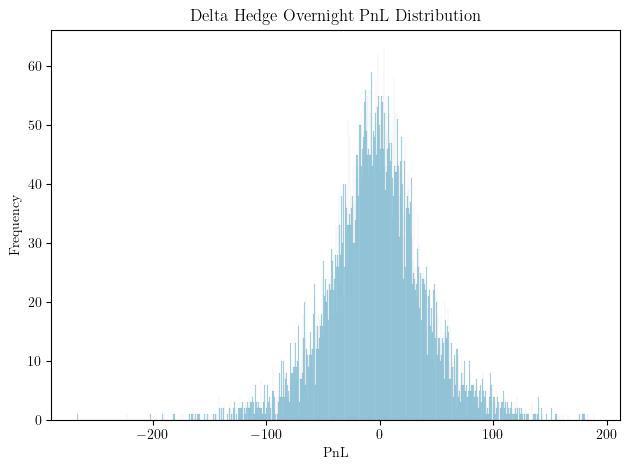

In [13]:
"""Plot the Overnight PnL Distributions"""

sns.histplot(overnight_pnl_per_path, bins=1000, color='skyblue')
plt.title("Delta Hedge Overnight PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

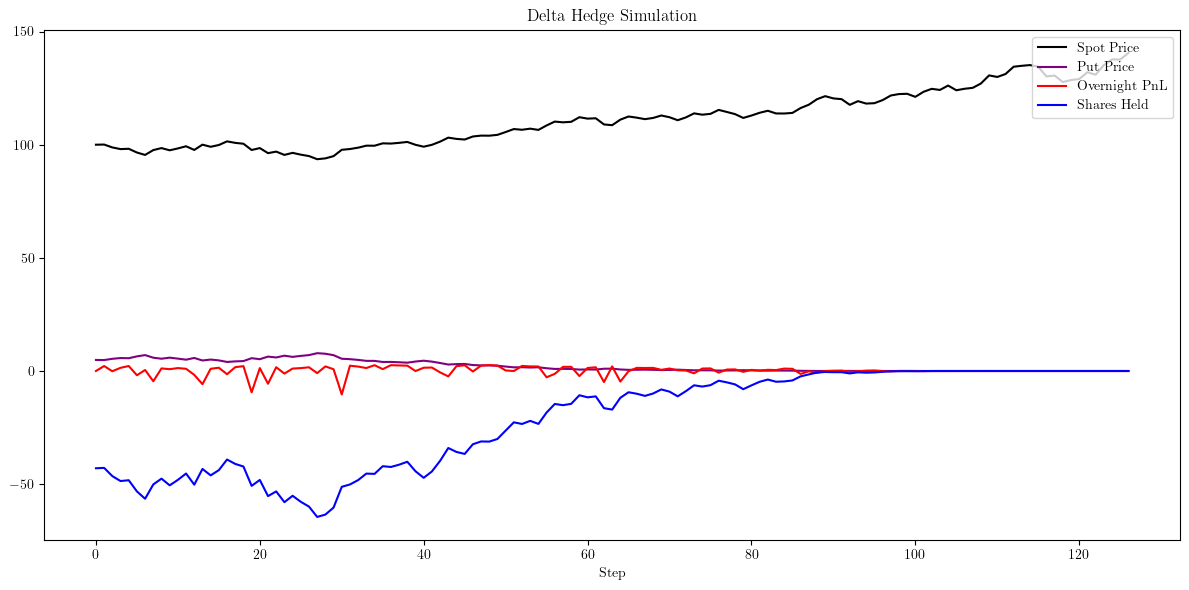

In [14]:
"""Plot the path simulation"""

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Delta Hedge Simulation")
ax1.set_xlabel("Step")
ax1.plot(df.index, df['spot'], label='Spot Price', color='black')
ax1.plot(df.index, df['option_price'], label='Put Price', color='purple')
ax1.plot(df.index, df['overnight_pnl'], label='Overnight PnL', color='red')
ax1.plot(df.index, df['shares'], label='Shares Held', color='blue')
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()